### The predict-Query

In the `intro_exampe.ipynb` notebook we have see how to create a model from data
and which fundamental queries there are available.
Here, we will have a look at the particular method `predict`.
This is extremely useful, since it allows one to formulate complex queries in a simple way, similar to how SQL queries are structured.

Let's create a model first:

In [1]:
from mb.data import mpg
import mb.modelbase as mbase
model = mbase.MixableCondGaussianModel("mpg").fit(df=mpg.mixed())

print(model.names)

['car_size', 'year', 'cylinder', 'displacement', 'mpg_city', 'mpg_highway']


Using the `predict` query we can combine the basic operations for querying densities or aggregations with conditioning or marginalization.

In practice, for instance, we might want to plot the marginal distribution over one variable, say `mpg_city`.
We can get the necessary density values like this:

In [2]:
from mb.modelbase import Density, Split, Aggregation

# get variable object
mpg_city = model.byname('mpg_city')

# query for density over
res = model.predict(Density(mpg_city), splitby=Split(mpg_city))
print(res)

    density(['mpg_city'])
0            1.144641e-03
1            3.247193e-03
2            1.147061e-02
3            4.277453e-02
4            1.294708e-01
5            2.770244e-01
6            4.064124e-01
7            4.230521e-01
8            3.451831e-01
9            2.481531e-01
10           1.644701e-01
11           9.995644e-02
12           5.518578e-02
13           2.728899e-02
14           1.185844e-02
15           4.463171e-03
16           1.448721e-03
17           4.081768e-04
18           1.015108e-04
19           2.289554e-05
20           4.846490e-06
21           9.921587e-07
22           1.985802e-07
23           3.840642e-08
24           7.018811e-09


Now we could use this to plot it

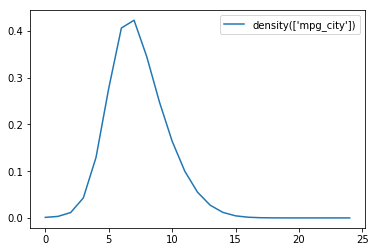

In [3]:
res.plot()

We can easily query for more points like this to make the curve smoother:

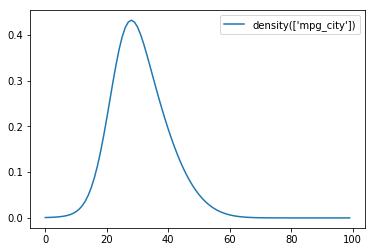

In [4]:
model.predict(Density(mpg_city), splitby=Split(mpg_city, args=[100] )).plot()

We can also use this syntax to systematically predict one variable given another.
Note how we use `Aggregation` instead of `Density`, and how the given variables is in the `Split`-clause.

In [5]:
car_size = model.byname('car_size')
model.predict(Aggregation(mpg_city), splitby=Split(car_size))

,mpg_city@maximum(['mpg_city'])
0,13.700191
1,19.758232
2,15.483792
3,17.303923
4,13.331982
5,14.653354
6,15.418866
7,19.150947
8,15.357625
9,16.743381


As you can see, this only returns the prediction for `mpg_city`.
To also include the predictor `car_size`, simply tell `predict` to do so.

Hence, this tables tells us the prediction of miles per gallon in the city for different car sizes:

In [6]:
model.predict(["car_size", Aggregation(mpg_city)], splitby=Split(car_size))

,car_size,mpg_city@maximum(['mpg_city'])
0,cargo van,13.700191
1,compact car,19.758232
2,large car,15.483792
3,midsize car,17.303923
4,passenger van,13.331982
5,pickup,14.653354
6,spv,15.418866
7,station wagon,19.150947
8,suv,15.357625
9,two seater,16.743381


Since we can freely choose what to predict and what to input, we can also swap the prediction.
Here, we predict the most likely `car_size` given a number of values for `mpg_city`.

In [7]:
model.predict(["mpg_city", Aggregation(car_size)], splitby=Split(mpg_city))

,mpg_city,car_size@maximum(['car_size'])
0,3.01296,two seater
1,4.93488,two seater
2,6.85680,two seater
3,8.77872,pickup
4,10.70064,pickup
5,12.62256,pickup
6,14.54448,pickup
7,16.46640,compact car
8,18.38832,compact car
9,20.31024,compact car


We can also apply filters (conditions) to such a query.
We can even predict multiple variables at once.
And, we can of course group by more than one group.
For the next query we only want to consider cars build after 1988,
and predict the to-be-expected miles per gallon in the city (`mpg_city`), as well as their number of cylinders (`cylinder`).
We will group the prediction by the `car_size` as well as by their `displacement`:

In [10]:
from mb.modelbase import Condition

displacement = model.byname('displacement')
year = model.byname('year')
cylinder = model.byname('cylinder')

In [18]:
res = model.predict(["car_size", "displacement", Aggregation(mpg_city), Aggregation(cylinder)],
                    splitby=[Split(car_size), Split(displacement)],
                    where=Condition(year, ">", 1988))

print(res)

       car_size  displacement  mpg_city@maximum(['mpg_city'])  \
0     cargo van     -0.959616                       22.522418   
1     cargo van     -0.560448                       21.894709   
2     cargo van     -0.161280                       21.267000   
3     cargo van      0.237888                       20.639291   
4     cargo van      0.637056                       20.011581   
..          ...           ...                             ...   
245  two seater      7.023744                        7.597138   
246  two seater      7.422912                        6.608243   
247  two seater      7.822080                        5.619348   
248  two seater      8.221248                        4.630453   
249  two seater      8.620416                        3.641558   

     cylinder@maximum(['cylinder'])  
0                          0.306662  
1                          0.768844  
2                          1.231026  
3                          1.693207  
4                          2.